In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import ray
from ray.rllib.agents import ppo

from mdps.whited import cMDPWhited
from utils.distributions import ConstantDistribution, ParticleDistribution, UniformDistribution

In [2]:
# collect expert rollout

def get_rollouts(solver_, config):
    """Generate rollouts from a given solver and MDP(c)"""
    env_ = cMDPWhited(config=config)
    done_ = False
    obs_ = env_.reset()
    # run until episode ends
    gt_obs_arr_ = obs_
    gt_act_arr_ = None
    gt_rew_arr_ = None
    while not done_:
        action_ = solver_.compute_single_action(obs_)
        obs_, rewawrd_, done_, _ = env_.step(action_)
        gt_obs_arr_ = np.vstack((gt_obs_arr_, obs_))
        if gt_act_arr_ is None:
            gt_act_arr_ = [action_]
            gt_rew_arr_ = [rewawrd_]
        else:
            gt_act_arr_ += [action_]
            gt_rew_arr_ += [rewawrd_]

    gt_act_arr_ = np.array(gt_act_arr_)
    gt_rew_arr_ = np.array(gt_rew_arr_)
    return gt_obs_arr_[1:,:], gt_act_arr_, gt_rew_arr_

def plot_rollouts(gt_obs_arr_, gt_act_arr_):
    """Plot generated rollouts"""
    fig_, ax_1 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_2 = ax_1.twinx()
    ax_1.plot(x, gt_obs_arr_[:,0], 'r-')
    ax_2.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_1.set_xlabel('time step')
    ax_1.set_ylabel('Capital(k)', color='r')
    ax_2.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

    fig_, ax_3 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_4 = ax_3.twinx()
    ax_3.plot(x, gt_obs_arr_[:,1], 'r-')
    ax_4.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_3.set_xlabel('time step')
    ax_3.set_ylabel('Shock(z)', color='r')
    ax_4.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

In [3]:
c = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15]))
    }

### ppo

In [4]:
ray.shutdown()
ray.init()

expert = ppo.PPOTrainer(env=cMDPWhited, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-07-04 13:42:38,598	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-07-04 13:42:38,598	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-07-04 13:42:41,754	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-07-04 13:42:53,091	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 490408957191.0x the scale of `vf_clip_param`. This means that it will take more than 490408957191.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


0 -4904089571914.061


2022-07-04 13:43:04,117	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 249389897264.0x the scale of `vf_clip_param`. This means that it will take more than 249389897264.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-07-04 13:43:14,562	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 75370584830.0x the scale of `vf_clip_param`. This means that it will take more than 75370584830.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-07-04 13:43:25,268	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 3137311355.0x the scale of `vf_clip_param`. This means that it will take more than 3137311355.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-07-04 13:43:36,617	WARNING ppo.py:245 -- The magnitude of your en

5 -2034518695.7884583


2022-07-04 13:43:57,434	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 4063851.0x the scale of `vf_clip_param`. This means that it will take more than 4063851.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-07-04 13:44:08,103	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1465143.0x the scale of `vf_clip_param`. This means that it will take more than 1465143.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-07-04 13:44:18,495	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 135063.0x the scale of `vf_clip_param`. This means that it will take more than 135063.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-07-04 13:44:29,015	WARNING ppo.py:245 -- The magnitude of your environment rewards are more

10 -5290.37472383079
15 623.8850094236006
20 718.8072039841511
25 774.103984894667
30 793.3502542544443


---

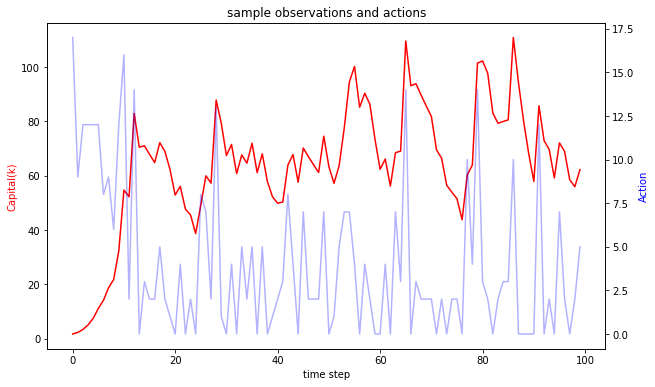

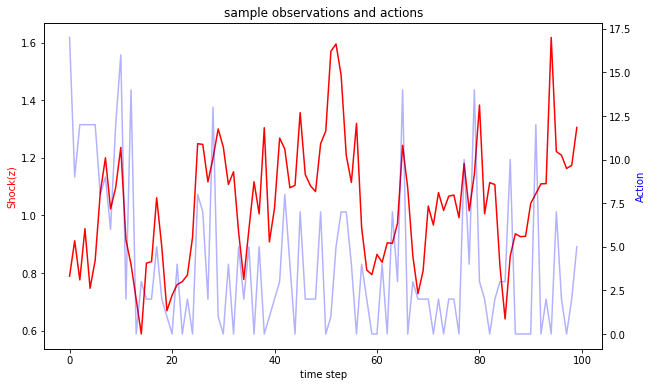

In [5]:
c_sim = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15]))
         }

gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert, config=c_sim)
plot_rollouts(gt_obs_arr, gt_act_arr)


In [10]:
N = 10000
T = 100

def posterior_sample_params(action=gt_act_arr, reward=gt_rew_arr, N=N, obs=gt_obs_arr,):
    theta_sample = np.random.normal(loc=1.,scale=1.,size=N)
    rho_sample = np.random.normal(loc=1.,scale=1.,size=N)
    sigma_sample = np.random.normal(loc=0.5,scale=1.,size=N)
    k = obs[:,0]
    z = obs[:,1]
    I = action.reshape(-1)*k/19
    r = reward.reshape(-1)

    for t in range(T-1):
        # evaluate probability of particles
        z_t = (r[t]+I[t])/k[t]**theta_sample

        eps_reward = np.log(z[t+1])-rho_sample*np.log(z_t)
        q_reward = stats.norm.pdf(eps_reward, loc=0, scale=sigma_sample)
        q_reward = np.nan_to_num(q_reward, copy=False)
        if q_reward.sum() == 0.0:
            continue

        eps = np.log(z[t+1])-rho_sample*np.log(z[t])
        q = stats.norm.pdf(eps, loc=0, scale=sigma_sample)
        q = np.nan_to_num(q, copy=False)
        # resample particles according to probability
        resample_index_reward = np.random.choice(np.arange(N), N, p=q_reward/q_reward.sum())
        theta_sample = theta_sample[resample_index_reward]
        theta_noise = np.random.normal(loc=0, scale=theta_sample.std(), size=theta_sample.shape) * 0.2
        theta_sample += theta_noise
        
        resample_index = np.random.choice(np.arange(N), N, p=q/q.sum())
        rho_sample = rho_sample[resample_index]
        rho_noise = np.random.normal(loc=0, scale=rho_sample.std(), size=rho_sample.shape) * 0.1
        rho_sample += rho_noise
        sigma_sample = sigma_sample[resample_index]
        sigma_noise = np.random.normal(loc=0, scale=sigma_sample.std(), size=sigma_sample.shape) * 0.2
        sigma_sample += sigma_noise

        if t % 25 == 0:
            print("round", t, "posterior mean", sigma_sample.mean())

    return theta_sample, rho_sample, sigma_sample

In [15]:
theta_prior = np.random.normal(loc=1.,scale=1.,size=N)
rho_prior = np.random.normal(loc=1.,scale=1.,size=N)
sigma_prior = np.random.normal(loc=0.5,scale=1.,size=N)

theta_post, rho_post, sigma_post = posterior_sample_params()

round 0 posterior mean 0.6189138465168489
round 25 posterior mean 0.185045469794733
round 50 posterior mean 0.16338857832691947
round 75 posterior mean 0.13265007427694342


In [16]:
print(theta_post.mean())
print(sigma_post.mean())

0.7133077009126895
0.1546259067887259


---

## 1. Estiamtion for $\sigma$

In [52]:
def filter_context(solver_,
                   context_distribution_,
                   gt_obs_arr_,
                   T_,
                   N_
                   ):
    state_arr_ = np.ones((N_,2))
    action_arr_ = np.zeros((N_,))
    context_history_ = []
    for t_ in range(T_):
        if t_ <= 5:
            continue
        # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
        qs_ = np.zeros((N_,))
        for n_ in range(N_):
            context_ = context_distribution_.particles[n_]
            c_local_ = {"context_distribution":
                           ConstantDistribution(dim=5, 
                                                constant_vector=context_)
            }
            env_ = cMDPWhited(config=c_local_)
            obs_ = env_.reset()
            if t_ > 0:
                env_.mdp.state = state_arr_[n_]
                obs_ = np.concatenate((np.array(env_.mdp.state), context_), axis=0).flatten()
            action_ = solver_.compute_single_action(obs_)
            obs_, reward_, _, _ = env_.step(action_)
            # estimate likelihood if r >= 1
            action_arr_[n_] = action_
            q = env_.likelihood(gt_obs_arr_[t_], action_arr_[n_], obs_, reward_)
            qs_[n_] = q
            state_arr_[n_] = np.copy(env_.mdp.state)
        if t_ >= 1:
            # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
            qs_ = np.clip(qs_, 0, np.percentile(qs_, 90))
            if qs_.sum() == 0:
                continue
            qs_ = qs_ / qs_.sum()
            resample_index_ = context_distribution_.resample_particles_from_probability(p=qs_)
            p_temp_ = context_distribution_.particles
            p_noise_ = np.random.normal(loc=0, scale=p_temp_.std(axis=0), size=p_temp_.shape) * 0.15
            context_distribution_.particles += p_noise_
            context_distribution_.particles = np.clip(context_distribution_.particles, 0.0, 1.0)
            state_arr_ = state_arr_[resample_index_]
            action_arr_ = action_arr_[resample_index_]
        if t_ % 10 == 0:
            print("round", t_, "posterior mean", context_distribution_.particles[:, 4].mean())
        context_history_ += [context_distribution_.particles.copy()]
    return context_history_, context_distribution_

### a. Exact context

In [58]:
# Estimation

N = 200
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.ones((N,)) * 0.7
rho = np.ones((N,)) * 0.7
sigma = np.random.uniform(0.05, 0.5, size=(N,))

context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
context_distribution = ParticleDistribution(dim=5, particles=context_particles, n_particles=N)

context_history_exact, _ = filter_context(expert,
                                          context_distribution,
                                          gt_obs_arr,
                                          T,
                                          N
                                          )

round 10 posterior mean 0.265498449474391


c:\Users\ZhenghaoJiang\Documents\GitHub\zhenghao_cmdp\mdps\whited.py:124: RuntimeWarning: invalid value encountered in log
  eps = np.log(z_curr)-rho*np.log(z_prev)


round 20 posterior mean 0.18026026196680467
round 30 posterior mean 0.12901820760940086
round 40 posterior mean 0.09602197695842546
round 50 posterior mean 0.08049191066756821
round 60 posterior mean 0.06512658907044287
round 70 posterior mean 0.056276980875275356
round 80 posterior mean 0.0476150533849733
round 90 posterior mean 0.04561101554777158


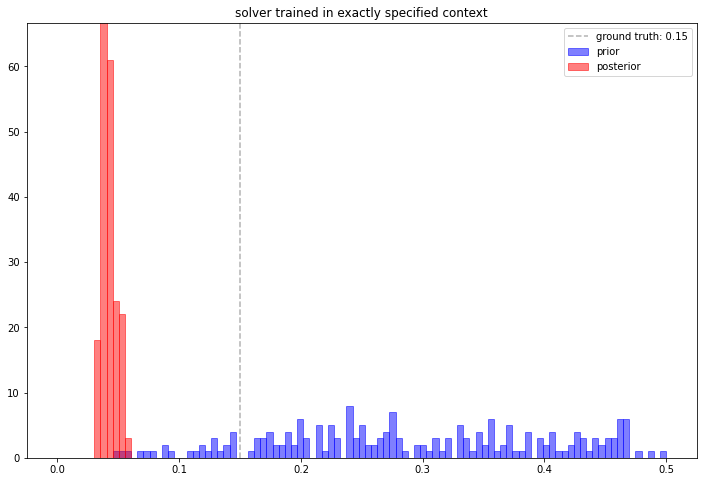

In [59]:
# Plot

fig, ax = plt.subplots()
HIST_BINS = np.linspace(0.0, 0.5, 100)
ax.hist(context_history_exact[0][:, 4], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_exact[-1][:, 4], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=0.15, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 0.15', 'prior', 'posterior'])
ax.set_ylim(top=N / 3)
fig.set_size_inches(12, 8)
plt.title('solver trained in exactly specified context')
plt.show()

### b. Misspecified sampled context

In [ ]:
# We add the sigma from 0.15 to 0.3 and keep others the same. 
c_mis = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.3]))
    }

ray.shutdown()
ray.init()

solver_mis = ppo.PPOTrainer(env=cMDPWhited, config={
    "env_config": c_mis,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = solver_mis.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

In [61]:
# Estimation

N = 200
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.ones((N,)) * 0.7
rho = np.ones((N,)) * 0.7
sigma = np.random.uniform(0.05, 0.5, size=(N,))

context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
context_distribution = ParticleDistribution(dim=5, particles=context_particles, n_particles=N)

context_history_mis, _ = filter_context(solver_mis,
                                          context_distribution,
                                          gt_obs_arr,
                                          T,
                                          N
                                          )

round 10 posterior mean 0.3444963894719733
round 20 posterior mean 0.3296584890732976
round 30 posterior mean 0.27572368088253674
round 40 posterior mean 0.24204177768042495
round 50 posterior mean 0.2219155926502284
round 60 posterior mean 0.1969368846785512
round 70 posterior mean 0.18563611506403732
round 80 posterior mean 0.18520542963953873
round 90 posterior mean 0.17764752242162832


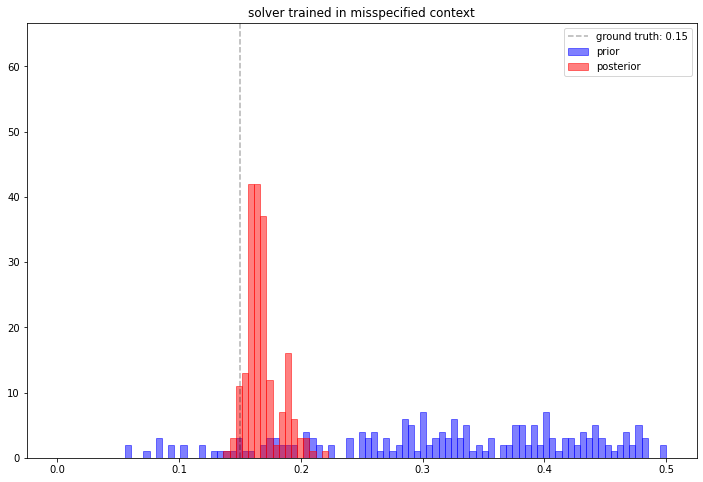

In [62]:
# Plot

fig, ax = plt.subplots()
HIST_BINS = np.linspace(0.0, 0.5, 100)
ax.hist(context_history_mis[0][:, 4], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_mis[-1][:, 4], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=0.15, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 0.15', 'prior', 'posterior'])
ax.set_ylim(top=N / 3)
fig.set_size_inches(12, 8)
plt.title('solver trained in misspecified context')
plt.show()

### c. Uniformly sampled context

In [143]:
# Uniformly sample sigma between 0.05 and 0.5
c_uniform = {'context_distribution':
             UniformDistribution(dim=5,
                                 lower_bound_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.05]),
                                 upper_bound_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.5]))}

ray.shutdown()
ray.init()
solver_uniform = ppo.PPOTrainer(env=cMDPWhited, config={
                                                    "env_config": c_uniform,
                                                    "framework": "torch",  # config to pass to env class
                                                })

rews = []
for eps in range(35):
    res = solver_uniform.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-01 22:48:11,637	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-01 22:48:20,887	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 908969038278.0x the scale of `vf_clip_param`. This means that it will take more than 908969038278.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


0 -9089690382784.74


2022-03-01 22:48:30,381	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 471266725497.0x the scale of `vf_clip_param`. This means that it will take more than 471266725497.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:48:39,775	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 209991752505.0x the scale of `vf_clip_param`. This means that it will take more than 209991752505.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:48:49,057	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 10509678127.0x the scale of `vf_clip_param`. This means that it will take more than 10509678127.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:48:58,229	WARNING ppo.py:245 -- The magnitude of you

5 -1128737973.9830532


2022-03-01 22:49:16,223	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 673758.0x the scale of `vf_clip_param`. This means that it will take more than 673758.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:49:25,285	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 135890.0x the scale of `vf_clip_param`. This means that it will take more than 135890.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:49:34,469	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 4878.0x the scale of `vf_clip_param`. This means that it will take more than 4878.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:49:43,824	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 65

10 -326.40136478347466
15 903.9820144971428
20 1015.5775851929072
25 1096.1838578889328
30 1133.5387834956032


In [144]:
# Estimation

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.ones((N,)) * 0.7
rho = np.ones((N,)) * 0.7
sigma = np.random.uniform(0.05, 0.5, size=(N,))

context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
context_distribution = ParticleDistribution(dim=5, particles=context_particles, n_particles=N)

context_history_uniform, _ = filter_context(solver_uniform,
                                          context_distribution,
                                          gt_obs_arr,
                                          T,
                                          N
                                          )

round 0 posterior mean 0.27229077869504303
round 25 posterior mean 0.05591523621015297
round 50 posterior mean 0.023894468771364117
round 75 posterior mean 0.02460360930173266


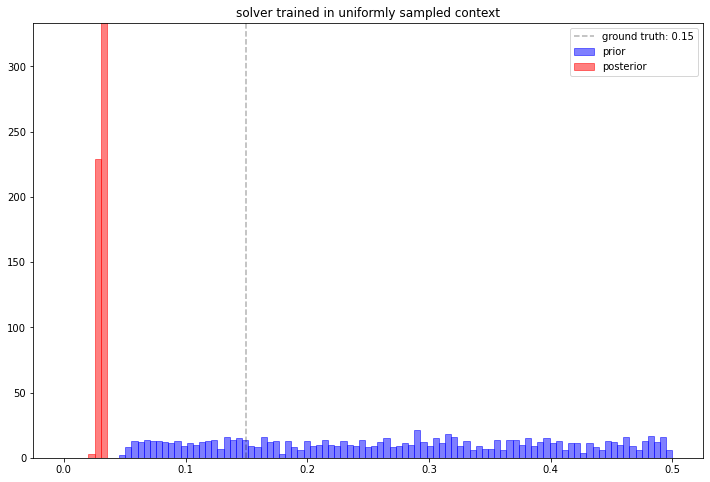

In [145]:
# Plot

fig, ax = plt.subplots()
HIST_BINS = np.linspace(0.0, 0.5, 100)
ax.hist(context_history_exact[0][:, 4], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_exact[-1][:, 4], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=0.15, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 0.15', 'prior', 'posterior'])
ax.set_ylim(top=N / 3)
fig.set_size_inches(12, 8)
plt.title('solver trained in uniformly sampled context')
plt.show()

### d. Importance sampling

2022-03-03 20:34:29,732	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 20:34:38,851	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1999139614588.0x the scale of `vf_clip_param`. This means that it will take more than 1999139614588.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 20:34:47,974	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1050365168985.0x the scale of `vf_clip_param`. This means that it will take more than 1050365168985.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 20:34:57,093	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 735631515840.0x the scale of `vf_clip_param`. This means that it will take more than 735631515840.0 iterations for your value function to converge. If this is not intended, consider 

round 0 posterior mean 0.27319177448085596
round 25 posterior mean 0.07513895516242726
round 50 posterior mean 0.05027671642247007
round 75 posterior mean 0.04757140929870149


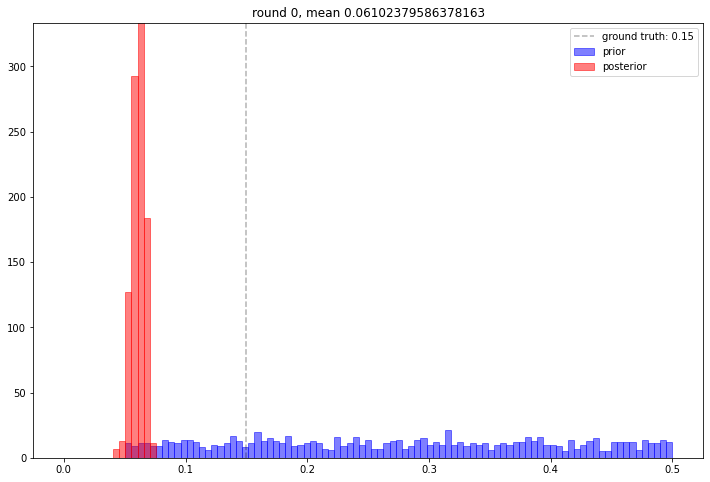

round 0 posterior mean 0.06102379586378163
round 25 posterior mean 0.06914334297554345
round 50 posterior mean 0.08641023049585067
round 75 posterior mean 0.09871915242075195


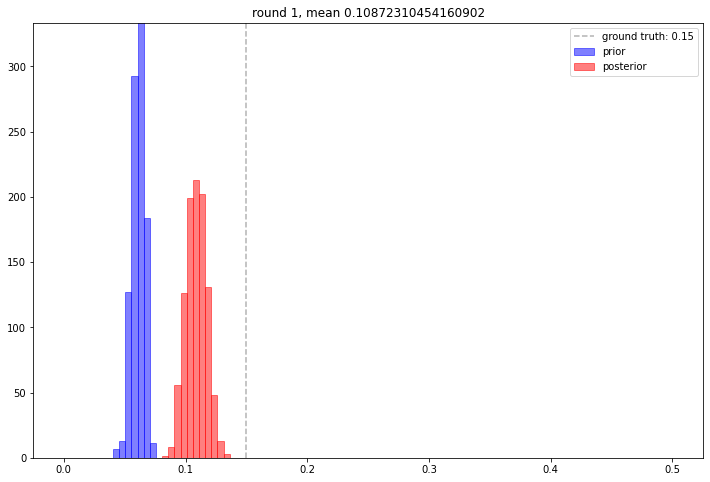

round 0 posterior mean 0.10872310454160902
round 25 posterior mean 0.10746433506313328
round 50 posterior mean 0.12351371866400948
round 75 posterior mean 0.14068245620391845


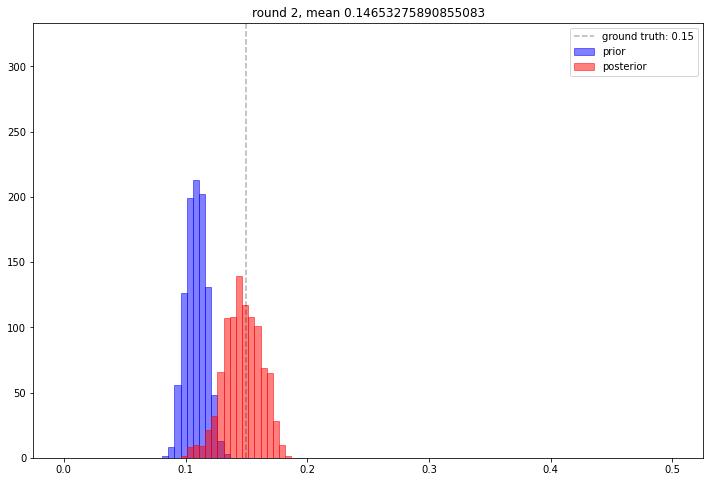

round 0 posterior mean 0.14653275890855083
round 25 posterior mean 0.14479900554177388
round 50 posterior mean 0.15869833795214855
round 75 posterior mean 0.17093143216444162


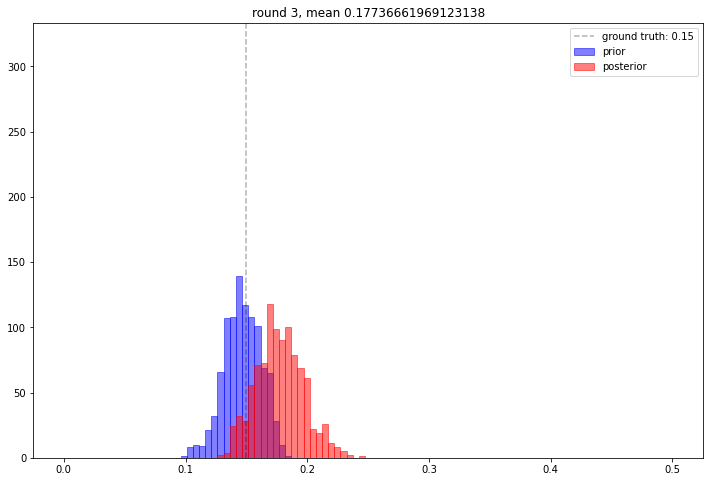

In [304]:
# Initialize prior

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.ones((N,)) * 0.7
rho = np.ones((N,)) * 0.7
sigma = np.random.uniform(0.05, 0.5, size=(N,))

prior_context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
imp_context_distribution = ParticleDistribution(dim=5, particles=prior_context_particles, n_particles=N)

ray.shutdown()
ray.init()

imp_solver = ppo.PPOTrainer(env=cMDPWhited, config={
                                                "env_config":  {"context_distribution": imp_context_distribution},
                                                "framework": "torch",  # config to pass to env class
                                            })

for update_round in range(4):
    # burn in training
    if update_round == 0:
        for i in range(20):
            imp_solver.train()

    context_history_imp, imp_context_distribution = filter_context(imp_solver,
                                       imp_context_distribution,
                                       gt_obs_arr,
                                       T,
                                       N
                                       )

    fig, ax = plt.subplots()
    HIST_BINS = np.linspace(0.0, 0.5, 100)
    ax.hist(context_history_imp[0][:, 4], HIST_BINS, lw=1,
            ec="blue", fc="blue", alpha=0.5)
    ax.hist(context_history_imp[-1][:, 4], HIST_BINS, lw=1,
            ec="red", fc="red", alpha=0.5)
    plt.axvline(x=0.15, alpha=0.3, color='black', linestyle='--')
    plt.legend(['ground truth: 0.15', 'prior', 'posterior'])
    ax.set_ylim(top=N / 3)
    fig.set_size_inches(12, 8)
    plt.title(f'round {update_round}, mean {context_history_imp[-1][:, 4].mean()}')
    plt.show()

    imp_solver.workers.foreach_worker(
                lambda ev: ev.foreach_env(
                    lambda env: env.set_task(imp_context_distribution)))
    if update_round < 3:
        for _ in range(5):
            imp_solver.train()


---